In [20]:
# necessary imports
from google.colab import files
import tensorflow as tf
from sklearn.datasets import load_files
import numpy as np
from keras.applications.resnet50  import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import os
import cv2
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import collections
from keras.models import load_model
from keras.layers import BatchNormalization, GlobalAveragePooling2D, MaxPool2D, Conv2D, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
import keras as K
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:


files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aamna27","key":"9944f09a800fd209ebde42468fb6f834"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:02<00:00, 168MB/s]
100% 346M/346M [00:02<00:00, 140MB/s]


In [ ]:
!unzip intel-image-classification.zip -d Dataset
!rm -rf /content/intel-image-classification.zip
!rm -rf /content/Dataset/seg_pred


In [8]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (32, 32))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [9]:
train_dir = "Dataset/seg_train/seg_train"
val_dir = "Dataset/seg_test/seg_test"
test_dir = "Dataset/seg_pred/seg_pred"

In [ ]:
!rm -rf /content/Dataset/seg_pred
!unzip Test_data.zip -d Dataset

In [11]:
print('loading train images')
X_train, y_train = load_data(train_dir)
print('loading test images')
X_val, y_val = load_data(val_dir)
print('loading test images')
X_test, y_test = load_data(test_dir)

  6%|▋         | 141/2191 [00:00<00:01, 1408.55it/s]

loading train images


 45%|████▌     | 197/437 [00:00<00:00, 1964.91it/s]

loading test images


 16%|█▋        | 187/1144 [00:00<00:00, 1865.83it/s]

loading test images


100%|██████████| 1236/1236 [00:00<00:00, 1829.71it/s]


In [13]:

all_acc_dict = 0
all_acc_dict = collections.OrderedDict()

accdict = {}

In [15]:

def res_tl(OPTIMIZER, LEARN_RATE, DECAY, MOMEMTUM, EPOCHS):
    input_t = K.Input(shape=(32,32,3))
    res_model = ResNet50(include_top=False,weights='imagenet', input_tensor= input_t)
    model = K.models.Sequential()
    model.add(res_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(512, activation='softmax'))
    model.add(K.layers.Dense(6, activation='softmax'))
    
    for layer in res_model.layers:
        layer.trainable=(1-True)
    if OPTIMIZER == "RMS":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS #in case you want to fix lr
      rms = K.optimizers.RMSprop(LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=rms)
    if OPTIMIZER == "Adam":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS #in case you want to fix lr
      adam = K.optimizers.Adam(LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    if OPTIMIZER == "SGD":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS #in case you want to fix lr
      sgd = SGD(lr=LEARN_RATE,  momentum=MOMEMTUM)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)

    return(model)

Adam


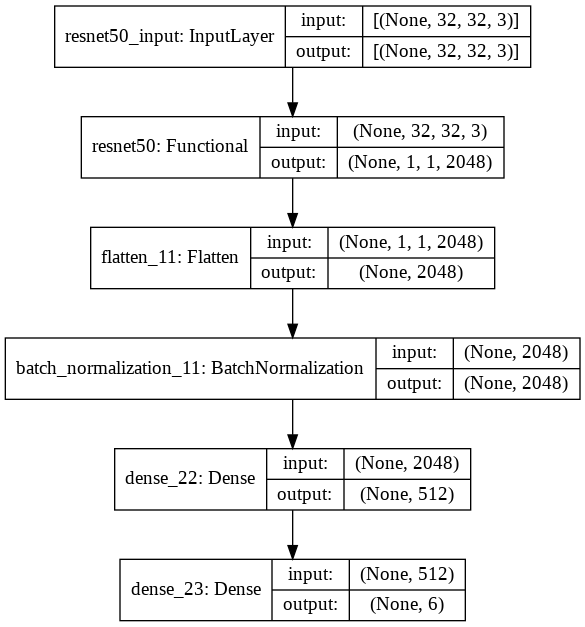

In [22]:
res_model_pic = res_tl("Adam", DECAY= 1e-7, MOMEMTUM = 0.9, LEARN_RATE =0.001, EPOCHS =75)
plot_model(res_model_pic, to_file='Results/RES-TL-model.png', show_shapes=True)

In [16]:


es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('CheckPoints/ResNet-TL-model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

def training(BATCH_SIZE, EPOCHS, OPTIMIZER, LEARN_RATE, DECAY = 0, MOMEMTUM = 0 ):
  accdict = {}
  res_model = res_tl(OPTIMIZER,LEARN_RATE, DECAY, MOMEMTUM, EPOCHS)
  H = res_model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, callbacks=[es,mc])
  trainacc = H.history['accuracy']
  valacc = H.history['val_accuracy']
  trainloss = H.history['loss']
  valloss = H.history['val_loss']
  test_loss, test_acc = res_model.evaluate(X_test, y_test, verbose=0)
  accdict["trainacc"] =trainacc[len(trainacc)-1]
  accdict["trainloss"] =trainloss[len(trainloss)-1]
  accdict["valacc"] = valacc[len(valacc)-1]
  accdict["valloss"] = valloss[len(valloss)-1]
  accdict["testacc"] = test_acc
  accdict["testloss"] = test_loss
  return H, accdict
  

In [17]:
History1, all_acc_dict["Adam_Exp1"] = training(32, 25, "Adam", 0.001)

History2, all_acc_dict["Adam_Exp2"] = training(64, 25, "Adam", 0.001)
History3, all_acc_dict["Adam_Exp3"] = training(128, 23,"Adam", 0.001) 

History4, all_acc_dict["SGD_Exp1"] = training(32, 23, "SGD", 0.001)
History5, all_acc_dict["SGD_Exp2"] = training(64, 23, "SGD", 0.001)
History6, all_acc_dict["SGD_Exp3"] = training(128, 23,"SGD", 0.001) 

History7, all_acc_dict["RMS_Exp1"] = training(32, 23, "RMS", 0.001)
History8, all_acc_dict["RMS_Exp2"] = training(64, 23, "RMS", 0.001)
History9, all_acc_dict["RMS_Exp3"] = training(128, 23,"RMS", 0.001) 

94773248/94765736 [==============================] - 1s 0us/step
Adam
Epoch 1/25
439/439 [==============================] - 17s 17ms/step - loss: 1.7868 - accuracy: 0.3613 - val_loss: 1.7713 - val_accuracy: 0.4107

Epoch 00001: val_accuracy improved from -inf to 0.41067, saving model to CheckPoints/ResNet-TL-model.h5
Epoch 2/25
439/439 [==============================] - 6s 14ms/step - loss: 1.7583 - accuracy: 0.4058 - val_loss: 1.7238 - val_accuracy: 0.3960

Epoch 00002: val_accuracy did not improve from 0.41067
Epoch 3/25
439/439 [==============================] - 6s 14ms/step - loss: 1.7171 - accuracy: 0.3972 - val_loss: 1.7009 - val_accuracy: 0.4017

Epoch 00003: val_accuracy did not improve from 0.41067
Epoch 4/25
439/439 [==============================] - 6s 14ms/step - loss: 1.6998 - accuracy: 0.3939 - val_loss: 1.6854 - val_accuracy: 0.4093

Epoch 00004: val_accuracy did not improve from 0.41067
Epoch 5/25
439/439 [==============================] - 6s 14ms/step - loss: 1.6826 - 

In [23]:

saved_model = load_model('CheckPoints/ResNet-TL-model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f,Val: %.3f, Test: %.3f' % (train_acc, val_acc,  test_acc))

Train: 0.506,Val: 0.496, Test: 0.514


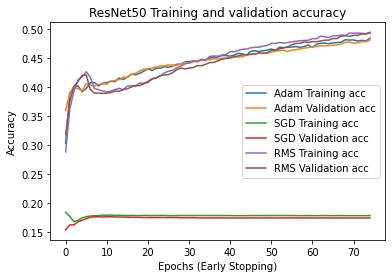

In [25]:

History =0
History = History1
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Accuracy')
plt.title('Transfer Learning using ResNet50 Accuracy')

plt.plot(epochs, acc, label='Adam Training acc')
plt.plot(epochs, val_acc, label='Adam Validation acc')

History =0
History = History5

acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='SGD Training acc')
plt.plot(epochs, val_acc, label='SGD Validation acc')



History =0
History = History7
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='RMS Training acc')
plt.plot(epochs, val_acc, label='RMS Validation acc')
plt.savefig("TLResNet50Historyacc.png")
plt.legend()


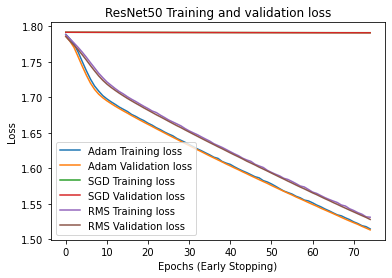

In [19]:

History = History1
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(acc))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Loss')
plt.title('Transfer Learning using ResNet50 Losses')

plt.plot(epochs, loss, label='Adam Training loss')
plt.plot(epochs, val_loss, label='Adam Validation loss')

History =0
History = History5
loss = History.history['loss']
val_loss = History.history['val_loss']
plt.plot(epochs, loss, label='SGD Training loss')
plt.plot(epochs, val_loss, label='SGD Validation loss')



History =0
History = History7
loss = History.history['loss']
val_loss = History.history['val_loss']
plt.plot(epochs, loss, label='RMS Training loss')
plt.plot(epochs, val_loss, label='RMS Validation loss')
plt.savefig("TLResNet50Historyloss.png")
plt.legend()


In [20]:
print( "{:<8} {:<15} {:<10}".format('Key','Label','Number'))
for k, v in all_acc_dict.items():
    trainacc, trainloss, valacc, valloss,testacc, testloss = v
    print(v)
    print( "".format(k, trainacc, trainloss, valacc, valloss,testacc, testloss ))

Key      Label           Number    
{'trainacc': 0.4848938286304474, 'trainloss': 1.514821171760559, 'valacc': 0.4816666543483734, 'valloss': 1.513411283493042, 'testacc': 0.5047253966331482, 'testloss': 1.5000061988830566}

{'trainacc': 0.46116572618484497, 'trainloss': 1.5967949628829956, 'valacc': 0.44999998807907104, 'valloss': 1.6001404523849487, 'testacc': 0.4703465402126312, 'testloss': 1.5908067226409912}

{'trainacc': 0.434231162071228, 'trainloss': 1.6512051820755005, 'valacc': 0.41466665267944336, 'valloss': 1.6544547080993652, 'testacc': 0.44322696328163147, 'testloss': 1.6485002040863037}

{'trainacc': 0.17899386584758759, 'trainloss': 1.7908529043197632, 'valacc': 0.17499999701976776, 'valloss': 1.7905670404434204, 'testacc': 0.17764689028263092, 'testloss': 1.790591835975647}

{'trainacc': 0.17899386584758759, 'trainloss': 1.7912060022354126, 'valacc': 0.17499999701976776, 'valloss': 1.7910772562026978, 'testacc': 0.17750993371009827, 'testloss': 1.7911447286605835}

{'t

In [24]:
from keras.models import load_model
saved_model = load_model('CheckPoints/ResNet-TL-model.h5')
predY = saved_model.predict(X_test)

In [25]:
#Confusion Matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score
from skimage import feature
from skimage import exposure
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
actual = pd.Series(y_test.ravel(),name='Actual')
predicted = pd.Series(predY.ravel(),name='Predicted')
predY_classes = predY.argmax(1)
y_test_classes = y_test.argmax(1)
confusion_matrix = pd.crosstab(y_test_classes, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
col_0    0     1     2     3     5   All
row_0                                   
0      482   169   144   126   223  1144
1       21   955    10    11   169  1166
2       83    69   643   457    78  1330
3       70    16   275   931     5  1297
4       47    22   192   844    23  1128
5      131   199   113    51   742  1236
All    834  1430  1377  2420  1240  7301


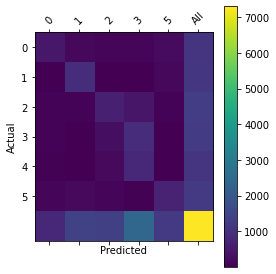

In [28]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  plt.matshow(df_confusion) # imshow
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.savefig("Results/SimpleResnetconfusion.jpg")
#call function
plot_confusion_matrix(confusion_matrix)